In [1]:
# init
import os
import json
from distutils.dir_util import mkpath

from IPython.display import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

os.chdir("../")

from misc.constants import event_mapping

pd.set_option("display.max_rows", 10)
plt.rc("axes.spines", top=False, right=False)
plt.ion()

np.random.seed(0x062217)

,t,x,y,status
0,0.000000,-0.559210,-0.217601,True
1,0.016667,0.249873,-0.664985,True
2,0.033333,0.547079,-0.203635,True
3,0.050000,-0.467449,0.273143,True
4,0.066667,0.960124,0.712988,True
...,...,...,...,...
55,0.916667,24.105887,-5.322831,True
56,0.933333,23.434387,-4.722465,True
57,0.950000,23.864152,-4.750229,True
58,0.966667,23.399366,-5.854043,True


Text(0.5, 0, 'Time, seconds')

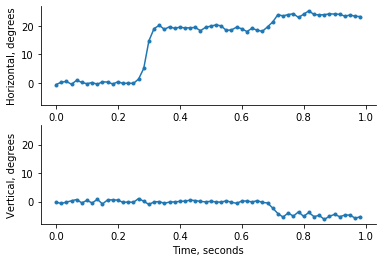

In [2]:
# create eye tracking data
fs = 60 # Hz
duration = 1 # s
n_samples = int(duration * fs)

timestamps = np.arange(0, duration, 1/fs)

# create saccades; uses sigmoid function
_x_saccade = np.linspace(-5, 5, 100)
saccade = 1/(1 + np.exp(-_x_saccade))

# 20 degree saccade, 4 sample (67 ms) duration
saccade1 = np.diff(saccade[::20] * 20, prepend=0)

# 5 degree saccade, 3 samples (50 ms) duration
saccade2 = np.diff(saccade[::25] * 5, prepend=0)

# create eye movement data
x = np.zeros(n_samples)
x[15:20]+=saccade1
x[40:44]+=saccade2
x = np.cumsum(x)

y = np.zeros(n_samples)
y[40:44]-=saccade2
y = np.cumsum(y)

# add random noise
noise_x = np.random.randn(n_samples) * 0.5
noise_y = np.random.randn(n_samples) * 0.5

# put everything together
etdata = pd.DataFrame(
    {
        "t": timestamps,
        "x": x + noise_x,
        "y": y + noise_y,
        "status": np.ones(n_samples, dtype=np.bool)
    }
)
display(etdata)

# plot data
fig, ax = plt.subplots(2, 1, sharey=True)
ax[0].plot(etdata["t"], etdata["x"], ".-")
ax[1].plot(etdata["t"], etdata["y"], ".-")

ax[0].set_ylabel("Horizontal, degrees")
ax[1].set_ylabel("Vertical, degrees")
ax[1].set_xlabel("Time, seconds")


In [ ]:
# create event data
display(event_mapping)

In [ ]:
gt = np.ones(n_samples, dtype=int)
gt[15:20] = gt[40:44] = 2 # ground truth saccades
display(gt)

In [ ]:
pr = np.ones(n_samples, dtype=int)
pr[13:19] = 2 # detected saccade
pr[19:21] = 3 # detected pso
pr[50:54] = 2 # detected false saccade
display(pr)

In [ ]:
# create and store ground truth and algorithm data
output_dir = "dev"
trial_name = "example.csv"

output_dir_gt = os.path.join(output_dir, "ECEM2022")
output_dir_pr = os.path.join(output_dir, "ECEM2022_algorithm")
mkpath(output_dir_gt)
mkpath(output_dir_pr)

print("Creating and saving ET data...")
etdata_gt = etdata.copy()
etdata_gt["evt"] = gt

etdata_pr = etdata.copy()
etdata_pr["evt"] = pr

etdata_gt.to_csv(os.path.join(output_dir_gt, trial_name), index=False)
etdata_pr.to_csv(os.path.join(output_dir_pr, trial_name), index=False)
print("done.")

In [ ]:
# setup evaluation job
root = output_dir
job_config = {
    "root": root,
    "event_map": {
        "1": 1,
        "2": 2,
        "3": 3
    },
    "multiclass_strategy": [
        "all",
        "ignore_matched_undef",
        "ignore_unmatched_undef",
        "ignore_undef"
    ],
    "binary_strategy": [
        "tn",
        "error",
        "ignore"
    ],
    "jobs": [
        {
            "gt": "ECEM2022",
            "pr": "ECEM2022_algorithm",
            "matchers": {
                "majority-voting": {},
                "plurality-voting": {},
                "overlap": {},
                "overlap/one-match": {"one-match-only": True},
                "earliest-overlap": {},
                "maximum-overlap": {},
                "iou": {},
                "iou/05": {
                    "iou_threshold": 0.5
                },
                "sample": {}
            }
        }
    ]
}

print("Saving evaluation job config...")
config_path = os.path.join(output_dir, "job_ECEM2022.json")
with open(config_path, "w") as fp:
    json.dump(job_config, fp, indent=4)
print("done.")

In [ ]:
# run evaluation
%run run_calc.py -job dev/job_ECEM2022.json

In [ ]:
# plot event matching; make sure "sample matcher" is not in the config
job_config["jobs"][0]["matchers"].pop("sample")

print("Saving updated evaluation job config...")
config_path = os.path.join(output_dir, "job_ECEM2022_plot.json")
with open(config_path, "w") as fp:
    json.dump(job_config, fp, indent=4)
print("done.")

%run run_calc.py -job dev/job_ECEM2022_plot.json --plot